## Imports

In [1]:
# Imports
import wikipedia
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import re
import requests
from bs4 import BeautifulSoup

## Functions

In [84]:
help_link_regex = re.compile("^/wiki/Help:")


# Gets the "first link" from a wikipedia page using the full URL
# Help from https://stackoverflow.com/questions/54170998/crawl-the-first-paragraph-link-in-wiki
def get_first_link(page_url, help_link_regex=help_link_regex):
    # Get page
    response = requests.get(page_url)
    html = response.text
    soup = BeautifulSoup(html, "html.parser")

    # Many pages lack a first link or have a strange structure requiring a lot of try statements

    # Paragraphs of the page
    paragraphs = (
        soup.find(id="mw-content-text").find(class_="mw-parser-output").find_all("p", recursive=False)
    )

    # Find all links in the first paragraph
    if len(paragraphs) > 5:
        filtered_paragaphs = [p for p in paragraphs[:4] if len(p) > 1]
    else:
        filtered_paragaphs = [p for p in paragraphs if len(p) > 1]

    link_list = []

    for p in filtered_paragaphs:
        p_links = p.find_all("a")
        # Leave them out if they match the previous RegEx
        for link in p_links:
            if not help_link_regex.match(link.get("href")):
                href = str(link.get("href"))
                link_class = str(link.get("class"))
                if (
                    "file:" not in href
                    and not href.endswith('.ogg')
                    and "#cite_note" not in href
                    and "upload.wikimedia.org" not in href\
                    and link_class != "['mw-redirect']"
                ):
                    link_list.append(href)
                    break
    try:
        first_link = link_list[0]

        # If the first href is blank, use the second
        if first_link == None:
            first_link = link_list[1]

        return first_link.split("/wiki/", 1)[1]

    # If it has no links, it is disconnected
    except IndexError:
        # NO LINKS
        original_name = page_url.split("https://en.wikipedia.org/wiki/", 1)[1]
        return original_name


In [87]:
# Testing the function. It should be 'Private_university'
get_first_link("https://en.wikipedia.org/wiki/georgetown_university")

'Private_university'

In [5]:
# Function that computes how far the average page is from the Philosophy page
def avg_dist_from_phil(G):
    distance_from_phil = []

    # Looping through nodes
    for node in G.nodes:

        # Only considers nodes that are connected to philosophy
        try:
            shortest_path_length = nx.shortest_path_length(G, node, "philosophy")
            distance_from_phil.append(shortest_path_length)

        except nx.NetworkXNoPath:
            continue

    # Return the mean
    return np.mean(distance_from_phil)

In [6]:
# Function that finds a new random page on Wikipedia
def wiki_random_page(seen_pages):

    # Set up while loop that searches 
    already_seen_page = True

    while already_seen_page:

        # Use the wikipedia api to find a random page
        random_page = wikipedia.random()
        
        # If it has already seen the page, go back up and try again
        if random_page in seen_pages:
            already_seen_page = True
            continue

        # Ignoring pages that are just lists of other pages and disambiguation because they are not 'real' wikipedia pages used for understanding a topic
        elif "list of " in random_page.lower() or "list_of" in random_page.lower():
            already_seen_page = True
        
        elif '(disambiguation)' in random_page.lower():
            already_seen_page = True

        # If it is a new page, return the page and its url
        else:
            page_url = "https://en.wikipedia.org/wiki/" + random_page.replace(" ", "_")
            already_seen_page = False

    return random_page, page_url

In [8]:
# Testing the function
seen_pages = ['philosophy']
wiki_random_page(seen_pages)

('Heroic Origins', 'https://en.wikipedia.org/wiki/Heroic_Origins')

In [58]:
# Function to expand the network
# New pages is the number of random pages that will be added to the network. All of the pages between these new pages and philosophy will also be added
def network_expander(G, page_url, seen_pages, is_root, fails, disconnects, convergence_df, new_pages=100):

    # If the DF already exists, this will be used later to ensure the iteration value is accurate
    start_iteration = len(convergence_df.index)

    # From experience, these are the most notable pages I want to focus on. If their centrality has converged, we can stop expanding the network
    notable_nodes = ["philosophy", "awareness", "knowledge", "science", "language", "philosophy_of_logic"]

    # Remove the link extra to get a cleaner page name
    root_page = page_url.lstrip("https://en.wikipedia.org/wiki/")

    # Running this once to save time
    help_link_regex = re.compile('^/wiki/Help:')
    
    # Pretty display of function progress 
    # Help from https://stackoverflow.com/questions/57473107/how-to-set-the-r-bar-part-of-tqdm
    for i in tqdm(range(new_pages), desc="Finding Paths", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}", colour="Green", ncols=75):
        # Get the first link
        print(page_url)
        full_first_link = get_first_link(page_url=page_url, help_link_regex=help_link_regex)

        # If it fails, find try a new random page
        if "!FAIL!: " in full_first_link:
            # We don't need to care if it was a root page
            if is_root:
                root_page, page_url = wiki_random_page(seen_pages)

            # If it as nodes connected to it, add it to a list of fails to be manually fixed
            else:
                fails.append(first_link)
                # print(full_first_link)
                root_page, page_url = wiki_random_page(seen_pages)
                full_first_link = get_first_link(page_url=page_url)
                
        elif "DEAD END: " in full_first_link:
            print("DISCONNECTED NODE AT:", root_page)
            disconnects.append(first_link)

            # New root
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True
            
        # Get the cleaner name for the node
        first_link = full_first_link.lstrip('/wiki/').lower()
        # print(first_link)

        # Add node
        G.add_node(first_link)
        # Add edge if there is one
        if not is_root:
            G.add_edge(old_page, first_link)
        
        # Every 25 iterations, once all of the notable nodes have been hit, check their key statistics
        if i % 25 == 0 and all([True if node in G.nodes else False for node in notable_nodes]):

            # Calculate values
            new_between_cent = nx.betweenness_centrality(G, endpoints='philosophy')
            new_closeness_cent = nx.closeness_centrality(G)
            new_in_degree_cent = nx.in_degree_centrality(G)

            # Get the values for key nodes
            new_between_cent = {key: new_between_cent[key] for key in notable_nodes}
            new_closeness_cent = {key: new_closeness_cent[key] for key in notable_nodes}
            new_in_degree_cent = {key: new_in_degree_cent[key] for key in notable_nodes}

            # Calculate average distance
            new_avg_dist = avg_dist_from_phil(G)

            # Function may take existing list, calculated at beginning of function
            iteration = start_iteration + i

            # Each node gets a row, these get filtered by the hue in the plots
            for node in notable_nodes:
                new_row = [iteration, node, new_between_cent[node], new_closeness_cent[node], new_in_degree_cent[node], new_avg_dist]
                convergence_df.loc[len(convergence_df.index)] = new_row


        # If it is philosophy, new root page
        if first_link.lower() == "philosophy":
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # If we have already seen where it goes, new root page
        elif first_link in seen_pages:
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # Page did a self loop! Not connected to philosophy
        elif first_link == root_page:
            print("DISCONNECTED NODE AT:", root_page)
            disconnects.append(first_link)

            # New root
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # Keep going until a known page is hit
        else:
            page_url = "https://en.wikipedia.org/" + full_first_link
            seen_pages.append(first_link)
            old_page = first_link
            is_root = False

    # Return key values
    return G, seen_pages, fails, disconnects, convergence_df


## Creating the Network

In [69]:
# Create Graph
G = nx.DiGraph()

# Add Philosophy as the first node
G.add_node("philosophy")

# Starting page, can be anything. I think Georgetown is a fun starting point but wikipedia.random() would work just as well
seed_page = "Georgetown University"
seed_page = seed_page.replace(" ", "_").lower()
is_root = True

# These start as the same thing
root_page = seed_page

# Create first url
first_page_url = "https://en.wikipedia.org/wiki/" + seed_page
old_page = seed_page

# List of pages already hit. This avoids finding the same paths for pages we already know.
seen_pages = ["philosophy"]

# List of fails
fails = []

# Not connected to philosophy
disconnects = []

# Create a dataframe that will be used to demonstrate the convergence of important pages
convergence_df = pd.DataFrame(columns=["iteration", "node", "betweeness_centrality", "closeness_centrality", "in_degree", "avg_dist_from_phil"])

In [89]:
# Function to expand the network
# New pages is the number of random pages that will be added to the network. All of the pages between these new pages and philosophy will also be added
def network_expander(G, page_url, seen_pages, is_root, fails, disconnects, convergence_df, new_pages=100):

    # If the DF already exists, this will be used later to ensure the iteration value is accurate
    start_iteration = len(convergence_df.index)

    # From experience, these are the most notable pages I want to focus on. If their centrality has converged, we can stop expanding the network
    notable_nodes = ["philosophy", "awareness", "knowledge", "science", "language", "philosophy_of_logic"]

    # Remove the link extra to get a cleaner page name
    root_page = page_url.split("https://en.wikipedia.org/wiki/", 1)[1]
    
    # Pretty display of function progress 
    # Help from https://stackoverflow.com/questions/57473107/how-to-set-the-r-bar-part-of-tqdm
    for i in tqdm(range(new_pages), desc="Finding Paths", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}", colour="Green", ncols=75):
        # Get the first link
        print(page_url)
        full_first_link = get_first_link(page_url=page_url)

        # If it fails, find try a new random page
        if "!FAIL!: " in full_first_link:
            # We don't need to care if it was a root page
            if is_root:
                root_page, page_url = wiki_random_page(seen_pages)

            # If it as nodes connected to it, add it to a list of fails to be manually fixed
            else:
                fails.append([seen_pages[-1], first_link])
                # print(full_first_link)
                root_page, page_url = wiki_random_page(seen_pages)
                full_first_link = get_first_link(page_url=page_url)
                is_root = True
                
        elif "DEAD END: " in full_first_link:
            print("DISCONNECTED NODE AT:", root_page)
            disconnects.append(first_link)

            # New root
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True
            
        # Get the cleaner name for the node
        first_link = full_first_link.lower()
        # print(first_link)

        # Add node
        G.add_node(first_link)
        # Add edge if there is one
        if not is_root:
            G.add_edge(old_page, first_link)
        
        # Every 25 iterations, once all of the notable nodes have been hit, check their key statistics
        if i % 25 == 0 and all([True if node in G.nodes else False for node in notable_nodes]):

            # Calculate values
            new_between_cent = nx.betweenness_centrality(G, endpoints='philosophy')
            new_closeness_cent = nx.closeness_centrality(G)
            new_in_degree_cent = nx.in_degree_centrality(G)

            # Get the values for key nodes
            new_between_cent = {key: new_between_cent[key] for key in notable_nodes}
            new_closeness_cent = {key: new_closeness_cent[key] for key in notable_nodes}
            new_in_degree_cent = {key: new_in_degree_cent[key] for key in notable_nodes}

            # Calculate average distance
            new_avg_dist = avg_dist_from_phil(G)

            # Function may take existing list, calculated at beginning of function
            iteration = start_iteration + i

            # Each node gets a row, these get filtered by the hue in the plots
            for node in notable_nodes:
                new_row = [iteration, node, new_between_cent[node], new_closeness_cent[node], new_in_degree_cent[node], new_avg_dist]
                convergence_df.loc[len(convergence_df.index)] = new_row


        # If it is philosophy, new root page
        if first_link.lower() == "philosophy":
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # If we have already seen where it goes, new root page
        elif first_link in seen_pages:
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # Page did a self loop! Not connected to philosophy
        elif first_link == root_page:
            print("DISCONNECTED NODE AT:", root_page)
            disconnects.append(first_link)

            # New root
            root_page, page_url = wiki_random_page(seen_pages)
            is_root = True

        # Keep going until a known page is hit
        else:
            page_url = "https://en.wikipedia.org/wiki/" + full_first_link
            seen_pages.append(first_link)
            old_page = first_link
            is_root = False

    # Return key values
    return G, seen_pages, fails, disconnects, convergence_df


In [6]:
# Debug check
notable_nodes = ["philosophy", "awareness", "knowledge", "science", "language", "philosophy_of_logic"]
[True if node in G.nodes else False for node in notable_nodes]

[True, True, True, True, True, True]

In [90]:
# Running the function
G, seen_pages, fails, disconnects, convergence_df = network_expander(
    G,
    page_url=first_page_url,
    seen_pages=seen_pages,
    is_root=True,
    fails=fails,
    disconnects=disconnects,
    convergence_df=convergence_df,
    new_pages=10,
)

Finding Paths:   0%|                                                 | 0/10

https://en.wikipedia.org/wiki/hotte
DISCONNECTED NODE AT: hotte


Finding Paths:  10%|████▉                                            | 1/10

https://en.wikipedia.org/wiki/Salvador_González


Finding Paths:  20%|█████████▊                                       | 2/10

https://en.wikipedia.org/wiki/Kingdom_of_Castile


Finding Paths:  30%|██████████████▋                                  | 3/10

https://en.wikipedia.org/wiki/Spanish_language


Finding Paths:  40%|███████████████████▌                             | 4/10

https://en.wikipedia.org/wiki/Romance_languages


Finding Paths:  50%|████████████████████████▌                        | 5/10

https://en.wikipedia.org/wiki/Wikipedia:Please_clarify


Finding Paths:  60%|█████████████████████████████▍                   | 6/10

https://en.wikipedia.org/wiki/Delaware's_17th_Senate_district


Finding Paths:  70%|██████████████████████████████████▎              | 7/10

https://en.wikipedia.org/wiki/Delaware


Finding Paths:  80%|███████████████████████████████████████▏         | 8/10

https://en.wikipedia.org/wiki/Cash–Landrum_incident


Finding Paths:  90%|████████████████████████████████████████████     | 9/10

https://en.wikipedia.org/wiki/Unidentified_flying_object


Finding Paths: 100%|████████████████████████████████████████████████| 10/10


In [79]:
fails

[['%cf%80%ce%bf%ce%bb%ce%b9%cf%84%ce%b9%ce%ba%ce%ac#ancient_greek',
  '%cf%80%ce%bf%ce%bb%ce%b9%cf%84%ce%b9%ce%ba%ce%ac#ancient_greek'],
 ['file:fr-normandie-marseille.ogg', 'file:fr-normandie-marseille.ogg'],
 ['vehiculum#latin', 'vehiculum#latin'],
 ['file:en-us-slovakia.ogg', 'file:en-us-slovakia.ogg'],
 ['file:it-italiano.ogg', 'file:it-italiano.ogg'],
 ['!fail!: hotte', '!fail!: hotte'],
 ['!fail!: zang', '!fail!: zang'],
 ['!fail!: wolfgang_pickl', '!fail!: wolfgang_pickl'],
 ['!fail!: 1965_palanca_awards', '!fail!: 1965_palanca_awards'],
 ['wikipedia:please_clarify', 'wikipedia:please_clarify'],
 ['!fail!: kjft', '!fail!: kjft'],
 ['%ce%ba%ce%af%ce%bd%ce%b7%ce%bc%ce%b1#ancient_greek',
  '%ce%ba%ce%af%ce%bd%ce%b7%ce%bc%ce%b1#ancient_greek'],
 ['file:ll-q150_(fra)-wikilucas00-commune.wav',
  'file:ll-q150_(fra)-wikilucas00-commune.wav']]

In [5]:
# Viewing the Convergence DF
convergence_df

,Unnamed: 0,iteration,node,betweeness_centrality,closeness_centrality,in_degree,avg_dist_from_phil
0,0,50,philosophy,0.015957,0.103663,0.042553,7.189189
1,1,50,awareness,0.015514,0.079856,0.021277,7.189189
2,2,50,knowledge,0.022163,0.090780,0.042553,7.189189
3,3,50,science,0.020833,0.067749,0.042553,7.189189
4,4,50,language,0.039894,0.039280,0.021277,7.189189
...,...,...,...,...,...,...,...
985,985,5960,philosophy,0.000290,0.077951,0.002514,11.856949
986,986,5960,awareness,0.000256,0.043812,0.000629,11.856949
987,987,5960,knowledge,0.000312,0.040557,0.001886,11.856949
988,988,5960,science,0.000360,0.037029,0.003457,11.856949


In [ ]:
def fail_fixer(G, fail, next_link, seen_pages):
    clean_name = fail.lstrip("!fail!: ")
    G = nx.relabel_nodes(G, {fail:clean_name})
    G.add_node(next_link)
    G.add_edge(clean_name, next_link)

    page_url = "https://en.wikipedia.org/wiki/" + next_link

    if next_link != "philosophy":
        philosophy_page = False
        old_page = next_link
    else: philosophy_page = True

    while not philosophy_page:
        full_first_link = get_first_link(page_url=page_url)
        # Get the cleaner name for the node
        first_link = full_first_link.lstrip('/wiki/').lower()
        # print(first_link)

        # Add node
        G.add_node(first_link)
        G.add_edge(old_page, first_link)
        

        # If it is philosophy, new root page
        if first_link.lower() == "philosophy":
            philosophy_page = True

        # If we have already seen where it goes, new root page
        elif first_link in seen_pages:
            philosophy_page = True

        # Keep going until a known page is hit
        else:
            page_url = "https://en.wikipedia.org/" + full_first_link
            seen_pages.append(first_link)
            old_page = first_link

    # Making sure it worked
    try:
        nx.shortest_path(G, fail, "philosophy")

    except nx.NodeNotFound:
        print("FAILED")

    return G, seen_pages

In [ ]:
G, seen_pages = fail_fixer(G, fail='!fail!: crime city', next_link="crime_film", seen_pages=seen_pages)

In [13]:
# Saving the network and DataFrame
first_link_path = './data/first-links.gml'
nx.write_gml(G, first_link_path)

convergence_df.to_csv("./data/convergence_data.csv")

## Analysis

### Convergence

In [39]:
# Reading the data in
first_link_path = './data/first-links.gml'
G = nx.read_gml(first_link_path)

convergence_df = pd.read_csv("./data/convergence_data.csv")
convergence_df.pop("Unnamed: 0")
convergence_df.head()

,iteration,node,betweeness_centrality,closeness_centrality,in_degree,avg_dist_from_phil
0,50,philosophy,0.015957,0.103663,0.042553,7.189189
1,50,awareness,0.015514,0.079856,0.021277,7.189189
2,50,knowledge,0.022163,0.090780,0.042553,7.189189
3,50,science,0.020833,0.067749,0.042553,7.189189
4,50,language,0.039894,0.039280,0.021277,7.189189


In [41]:
total_iterations = max(convergence_df['iteration'])
last_1000_iterations = convergence_df[convergence_df["iteration"] >= total_iterations - 1000]
last_1000_iterations.reset_index(inplace=True)
last_1000_iterations.head()

,index,iteration,node,betweeness_centrality,closeness_centrality,in_degree,avg_dist_from_phil
0,820,4970,philosophy,0.000344,0.079448,0.002213,11.746445
1,821,4970,awareness,0.000307,0.045047,0.000738,11.746445
2,822,4970,knowledge,0.000376,0.041818,0.002213,11.746445
3,823,4970,science,0.000439,0.038827,0.003320,11.746445
4,824,4970,language,0.001239,0.064699,0.005164,11.746445


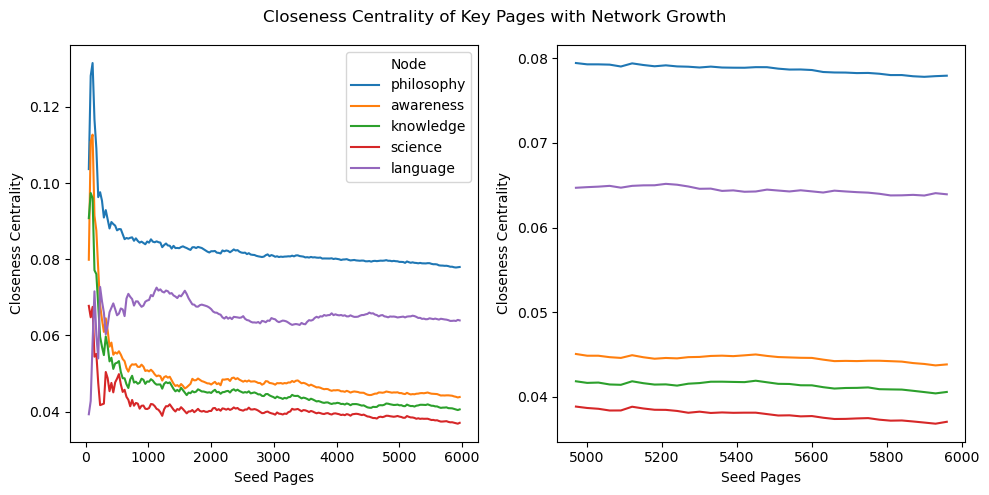

In [69]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(convergence_df, x="iteration", y="closeness_centrality", hue="node", ax=ax1)
ax1.set_ylabel("Closeness Centrality")
ax1.set_xlabel("Seed Pages")
legend = ax1.legend()
legend.set_title("Node")

sns.lineplot(last_1000_iterations, x="iteration", y="closeness_centrality", hue="node", ax=ax2, legend=False)
ax2.set_ylabel("Closeness Centrality")
ax2.set_xlabel("Seed Pages")

plt.suptitle("Closeness Centrality of Key Pages with Network Growth")
plt.tight_layout()

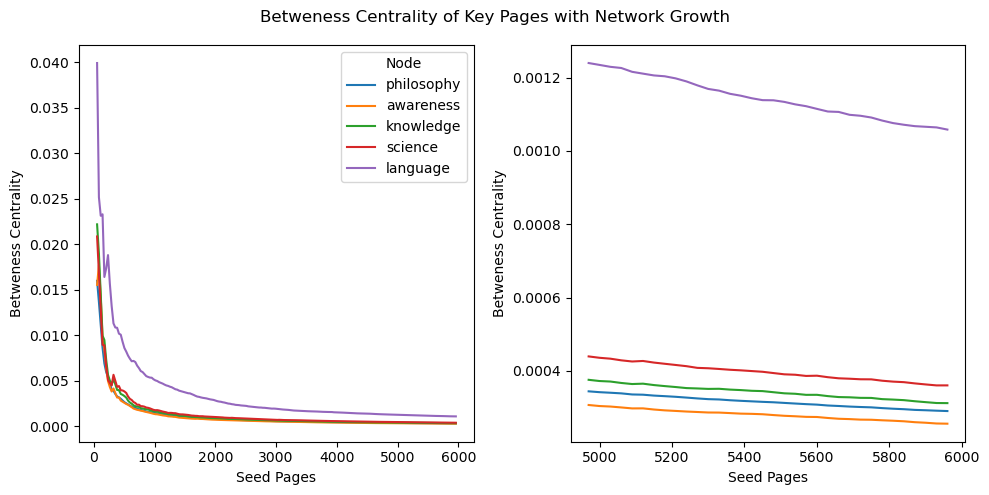

In [70]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(convergence_df, x="iteration", y="betweeness_centrality", hue="node", ax=ax1)
ax1.set_ylabel("Betweness Centrality")
ax1.set_xlabel("Seed Pages")
legend = ax1.legend()
legend.set_title("Node")

sns.lineplot(last_1000_iterations, x="iteration", y="betweeness_centrality", hue="node", ax=ax2, legend=False)
ax2.set_ylabel("Betweness Centrality")
ax2.set_xlabel("Seed Pages")

plt.suptitle("Betweness Centrality of Key Pages with Network Growth")
plt.tight_layout()

In [13]:
def differences_to_previous(arr):
    if len(arr) < 2:
        return []  # Cannot calculate differences with less than two elements

    differences = [(arr[i] - arr[i - 1]) *100 for i in range(len(arr) - 4, len(arr)-1)] 
    return differences

# Example usage:
result = differences_to_previous(np.array(convergence_df["in_degree"][convergence_df['node']=='language']))
print(result)

[-0.0024450811843399443, -0.002119102650850052, -0.0022496962909999453]


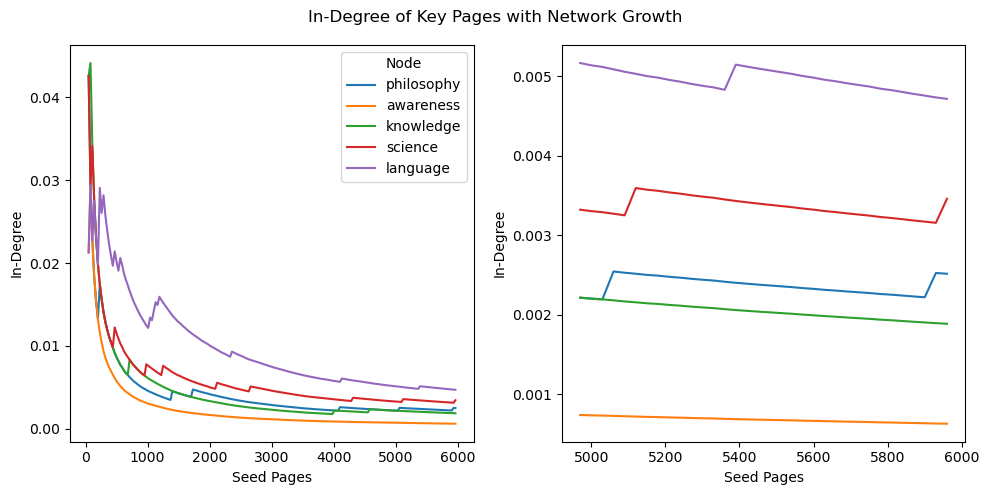

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(convergence_df, x="iteration", y="in_degree", hue="node", ax=ax1)
ax1.set_ylabel("In-Degree")
ax1.set_xlabel("Seed Pages")
legend = ax1.legend()
legend.set_title("Node")

sns.lineplot(last_1000_iterations, x="iteration", y="in_degree", hue="node", ax=ax2, legend=False)
ax2.set_ylabel("In-Degree")
ax2.set_xlabel("Seed Pages")


plt.suptitle("In-Degree of Key Pages with Network Growth")
plt.tight_layout()

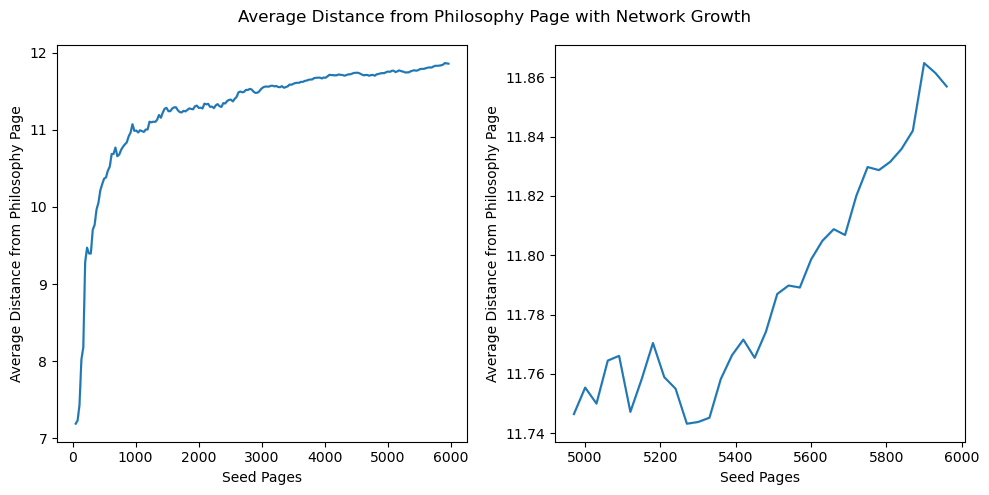

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(convergence_df, x="iteration", y="avg_dist_from_phil", ax=ax1)
ax1.set_ylabel("Average Distance from Philosophy Page")
ax1.set_xlabel("Seed Pages")


sns.lineplot(last_1000_iterations, x="iteration", y="avg_dist_from_phil", ax=ax2, legend=False)
ax2.set_ylabel("Average Distance from Philosophy Page")
ax2.set_xlabel("Seed Pages")


plt.suptitle("Average Distance from Philosophy Page with Network Growth")
plt.tight_layout()

Look into core decompositions for displaying the network. Force directed would be better but is slow. 
Switch it to a directed graph.

In [27]:
# ------------------------------
# NETWORK PLOTTING FUNCTION
# ------------------------------
def plot_network(G, node_color="degree", layout="random"):
    # INITALIZE PLOT
    fig, ax = plt.subplots()
    fig.set_size_inches(20, 20)

    # NODE COLORS
    cmap = plt.cm.get_cmap("Greens")

    # DEGREE
    if node_color == "degree":
        centrality = list(dict(nx.degree(G)).values())

    # BETWENNESS
    if node_color == "betweeness":
        centrality = list(dict(nx.betweenness_centrality(G, endpoints="philosophy")).values())

    # CLOSENESS
    if node_color == "closeness":
        centrality = list(dict(nx.closeness_centrality(G)).values())

    # NODE SIZE CAN COLOR
    node_colors = [cmap(u / (0.01 + max(centrality))) for u in centrality]
    node_sizes = [10000 * u / (0.001 + max(centrality)) for u in centrality]

    scaled_node_sizes = [size if size > 3000 else 100 for size in node_sizes]

    scale = [size / max(node_sizes) for size in scaled_node_sizes]

    # POSITIONS LAYOUT
    N = len(G.nodes)
    if layout == "spring":
        # pos=nx.spring_layout(G,k=50*1./np.sqrt(N),iterations=100)
        pos = nx.spring_layout(G, scale=scale)

    if layout == "random":
        pos = nx.random_layout(G)

    if layout == "spiral":
        pos = nx.spiral_layout(G, scale=scale)

    if layout == "spectral":
        pos = nx.spectral_layout(G, scale=scale)
    
    if layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G)

    # PLOT NETWORK
    nx.draw(
        G,
        edgecolors="black",
        node_color=node_colors,
        node_size=scaled_node_sizes,
        pos=pos,
        with_labels=True
    )

    plt.show()


# G.remove_edges_from(nx.selfloop_edges(G))
# plot_network(nx.k_core(G, 50), node_color="degree", layout="spectral")


In [28]:
degree_dict = dict(G.in_degree())

# Create a dataframe with nodes and their degrees
df_nodes = pd.DataFrame.from_dict(degree_dict, orient='index', columns=['Degree'])

# Sort the dataframe by degree in descending order
df_nodes_sorted = df_nodes.sort_values(by='Degree', ascending=False)

df_nodes_sorted.head(10)

,Degree
french_language,32
sport,24
german_language,21
u.s._state,19
physics,17
public_university,16
family_(biology),16
biology,16
association_football,16
language,15


In [236]:
def fail_fixer(G, fail, next_link, seen_pages):
    clean_name = fail.lstrip("!fail!: ")
    G = nx.relabel_nodes(G, {fail:clean_name})
    G.add_node(next_link)
    G.add_edge(clean_name, next_link)

    page_url = "https://en.wikipedia.org/wiki/" + next_link

    if next_link != "philosophy":
        philosophy_page = False
        old_page = next_link
    else: philosophy_page = True

    while not philosophy_page:
        full_first_link = get_first_link(page_url=page_url)
        # Get the cleaner name for the node
        first_link = full_first_link.lstrip('/wiki/').lower()
        # print(first_link)

        # Add node
        G.add_node(first_link)
        G.add_edge(old_page, first_link)
        

        # If it is philosophy, new root page
        if first_link.lower() == "philosophy":
            philosophy_page = True

        # If we have already seen where it goes, new root page
        elif first_link in seen_pages:
            philosophy_page = True

        # Keep going until a known page is hit
        else:
            page_url = "https://en.wikipedia.org/" + full_first_link
            seen_pages.append(first_link)
            old_page = first_link

    # fails = fails[True if f[0]!=fail else False for f in fails]

    return G, seen_pages

In [133]:
disconnects

[]

In [29]:
# Calculate the degrees of each node
degrees = dict(G.degree())

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by degree:")
for node, degree in sorted_nodes[:10]:
    print(f"{node}: {degree}")

Top nodes by degree:
french_language: 33
sport: 25
german_language: 22
u.s._state: 20
physics: 18
biology: 17
family_(biology): 17
association_football: 17
public_university: 17
language: 16


In [5]:
# Calculate the degrees of each node
in_degree = dict(nx.in_degree_centrality(G))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(in_degree.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by in_degree:")
for node, degree in sorted_nodes[:10]:
    print(f"{node}: {degree}")

Top nodes by in_degree:
biology: 0.008990318118948825
sport: 0.00760719225449516
physics: 0.00760719225449516
ancient_greek_language: 0.006915629322268327
french_language: 0.006915629322268327
help:pronunciation_respelling_key: 0.006915629322268327
language: 0.006224066390041494
language_family: 0.006224066390041494
german_language: 0.005532503457814661
team_sport: 0.005532503457814661


In [30]:
# Calculate the degrees of each node
out_degree = dict(nx.out_degree_centrality(G))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(out_degree.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by out_degree:")
for node, degree in sorted_nodes[:10]:
    print(f"{node}: {degree}")

Top nodes by out_degree:
private_university: 0.00031298904538341156
higher_education: 0.00031298904538341156
tertiary_education: 0.00031298904538341156
education: 0.00031298904538341156
knowledge: 0.00031298904538341156
awareness: 0.00031298904538341156
ologamasidae: 0.00031298904538341156
mesostigmata: 0.00031298904538341156
mite: 0.00031298904538341156
arachnid: 0.00031298904538341156


In [31]:
neighbors = [n[0] for n in list(G.in_edges("philosophy"))]
neighbor_degrees = [G.in_edges(n) for n in neighbors]
neighbors

['awareness',
 'philosophy_of_logic',
 'metaphysics',
 'aesthetics',
 'philosophical_tradition',
 'philosophy_of_culture',
 'philosopher_of_science',
 'post-structuralism',
 'american_enlightenment']

In [22]:
# Calculate the degrees of each node
betweeness_centrality = dict(nx.betweenness_centrality(G))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(betweeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by betweeness centrality:")
for node, betweeness_centrality in sorted_nodes[:10]:
    print(f"{node}: {betweeness_centrality}")

Top nodes by betweeness centrality:
language: 0.0009048656371541711
communication: 0.0007594443023548653
information: 0.0006224503494913683
greek_language: 0.0005950123617933861
modern_greek: 0.000541900257035149
classical_language: 0.0004973135270259279
dialect: 0.000491237972607089
latin: 0.0004789888709562041
abstraction: 0.0004674257189977687
ancient_greek_language: 0.00037864423023215477


In [23]:
# Calculate the degrees of each node
closeness_centrality = dict(nx.closeness_centrality(G))

# Sort the nodes by degree (in descending order)
sorted_nodes = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top nodes by degree
print("Top nodes by closeness centrality:")
for node, closeness_centrality in sorted_nodes[:10]:
    print(f"{node}: {closeness_centrality}")

Top nodes by closeness centrality:
philosophy: 0.07799515336360505
language: 0.06396213345647656
communication: 0.057169937013126004
information: 0.05315005032062935
abstraction: 0.04813063294609507
rule_of_inference: 0.043938950906059974
awareness: 0.043633915044049155
philosophy_of_logic: 0.040424984350946484
knowledge: 0.0403916515854906
science: 0.0368787024455844


In [25]:
distance_from_phil = []
path_to_phil = []
nodes = []
for node in G.nodes:
    try:
        shortest_path = nx.shortest_path(G, node, "philosophy")
        shortest_path_length = nx.shortest_path_length(G, node, "philosophy")
        nodes.append(node)
        distance_from_phil.append(shortest_path_length)
        path_to_phil.append(shortest_path)
    except nx.NetworkXNoPath:
        shortest_path = np.NAN
        shortest_path_length = np.NAN
        continue


# nodes  = [n for n in G.nodes]
df = pd.DataFrame(
    {"node": nodes, "distance": distance_from_phil, "shortest_path": path_to_phil}
)
print("AVERAGE DISTANCE TO PHILOSOPHY: ", np.mean(distance_from_phil))
df.sort_values("distance", inplace=True)
df.reset_index(inplace=True)
df.pop("index")
nodes = df["node"]
distances = df["distance"]
paths = df["shortest_path"]
print(
    "FURTHEST NODE: ",
    nodes[len(nodes) - 1],
    " is ",
    distances[len(distances) - 1],
    " pages away with a path of: ",
    paths[len(distances) - 1],
)
print(
    "THERE ARE "
    + str(
        sum([True if distance == max(distances) else False for distance in distances])
    )
    + " paths with a distance of "
    + str(max(distances))
)


AVERAGE DISTANCE TO PHILOSOPHY:  11.854194857916102
FURTHEST NODE:  john_gavin_(director)  is  24  pages away with a path of:  ['john_gavin_(director)', 'bushrangers', 'convicts_in_australia', 'penal_transportation', 'convict', 'guilt_(law)', 'criminal_law', 'law', 'law_enforcement', 'government', 'state_(polity)', 'politics', 'ancient_greek_language', 'greek_language', 'modern_greek', 'dialect', 'latin', 'classical_language', 'language', 'communication', 'information', 'abstraction', 'rule_of_inference', 'philosophy_of_logic', 'philosophy']
THERE ARE 2 paths with a distance of 24


In [32]:
ten_away = df[df['distance'] <= 5]

subgraph = G.subgraph(ten_away['node'])

plot_network(subgraph, node_color="closeness", layout="kamada_kawai")

In [138]:
plot_network(subgraph, node_color="betweeness", layout="kamada_kawai")

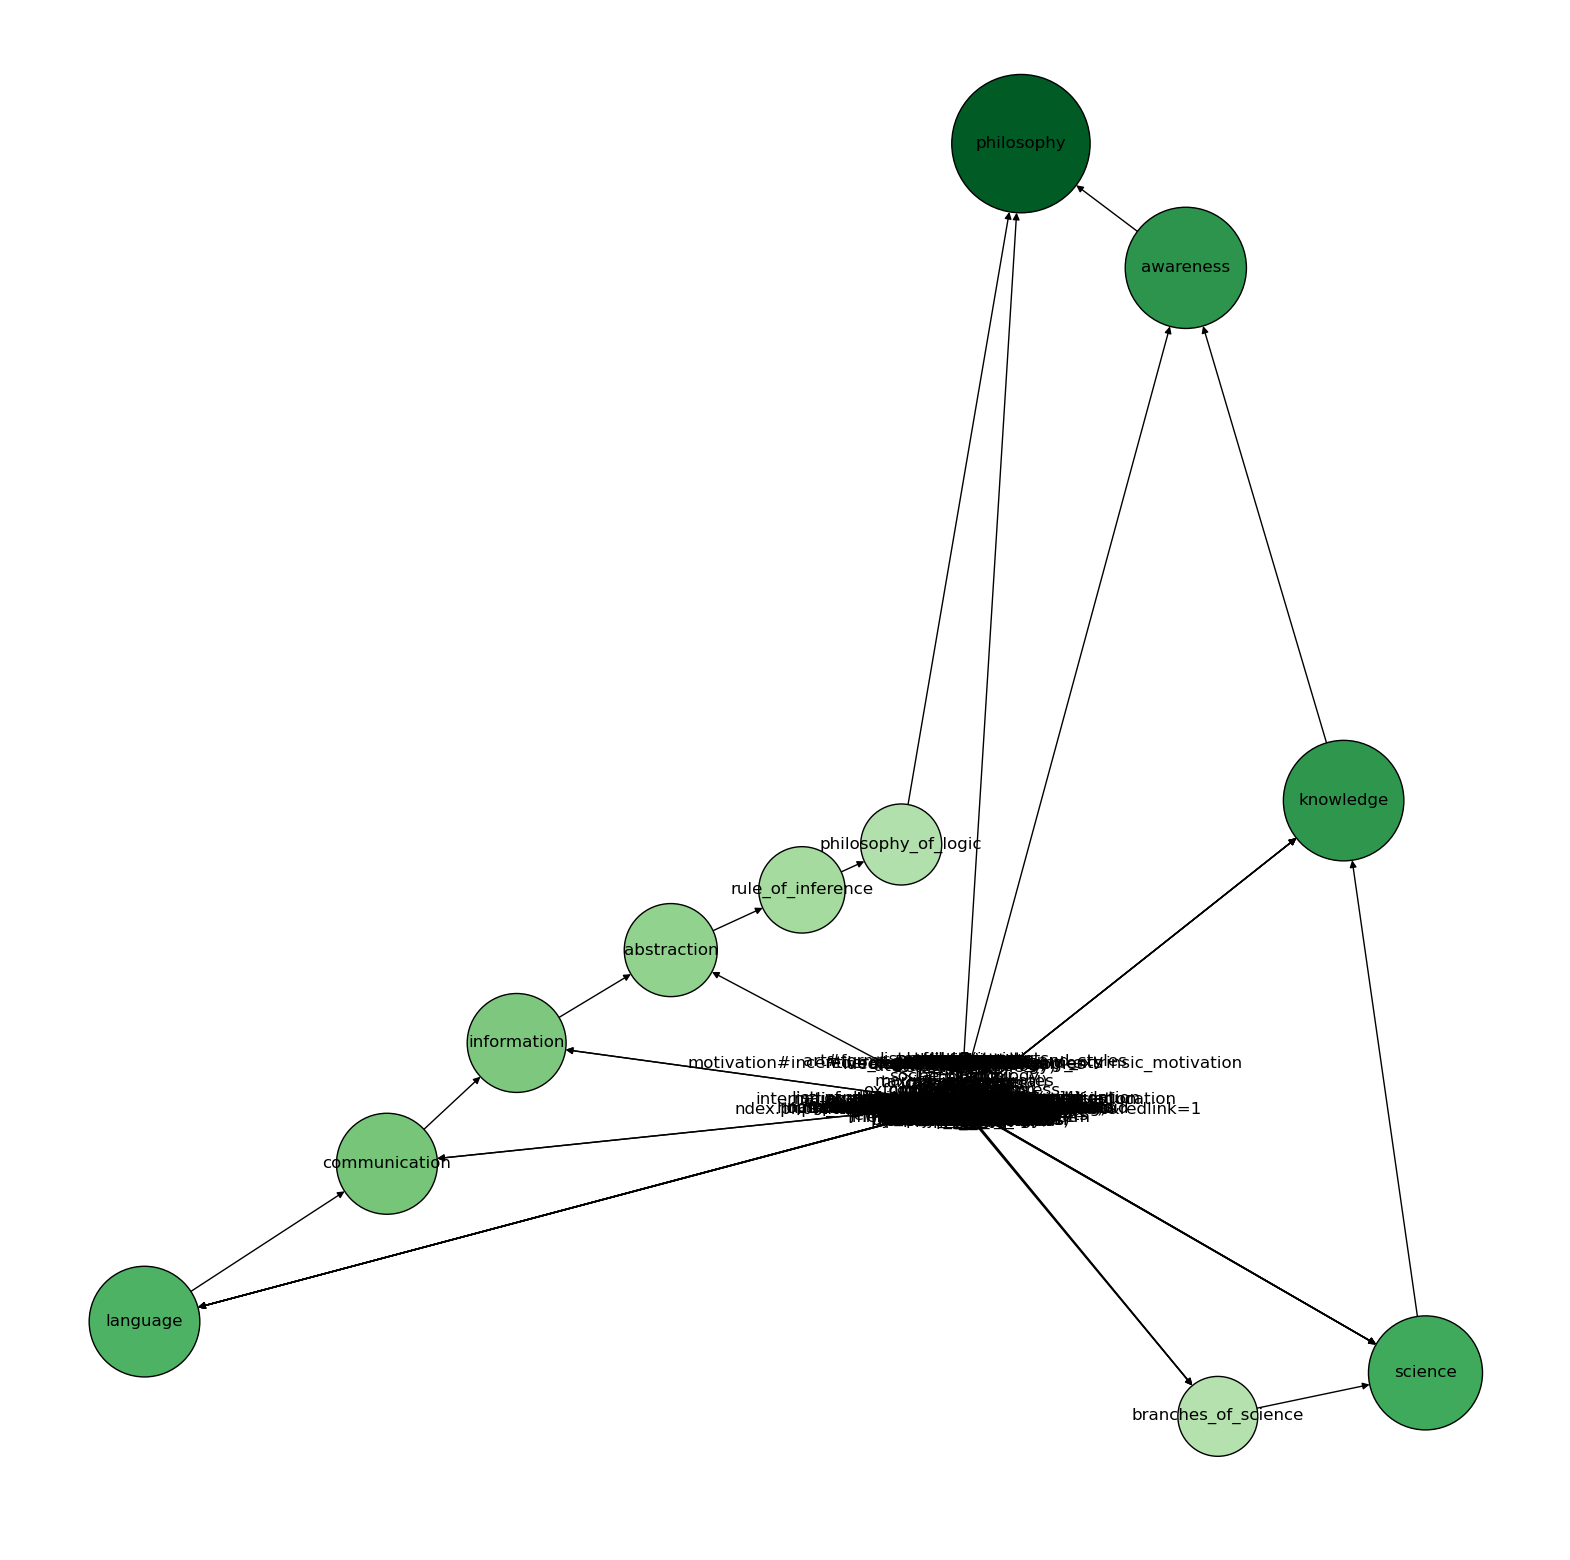

In [251]:
plot_network(subgraph, node_color="closeness", layout="spectral")

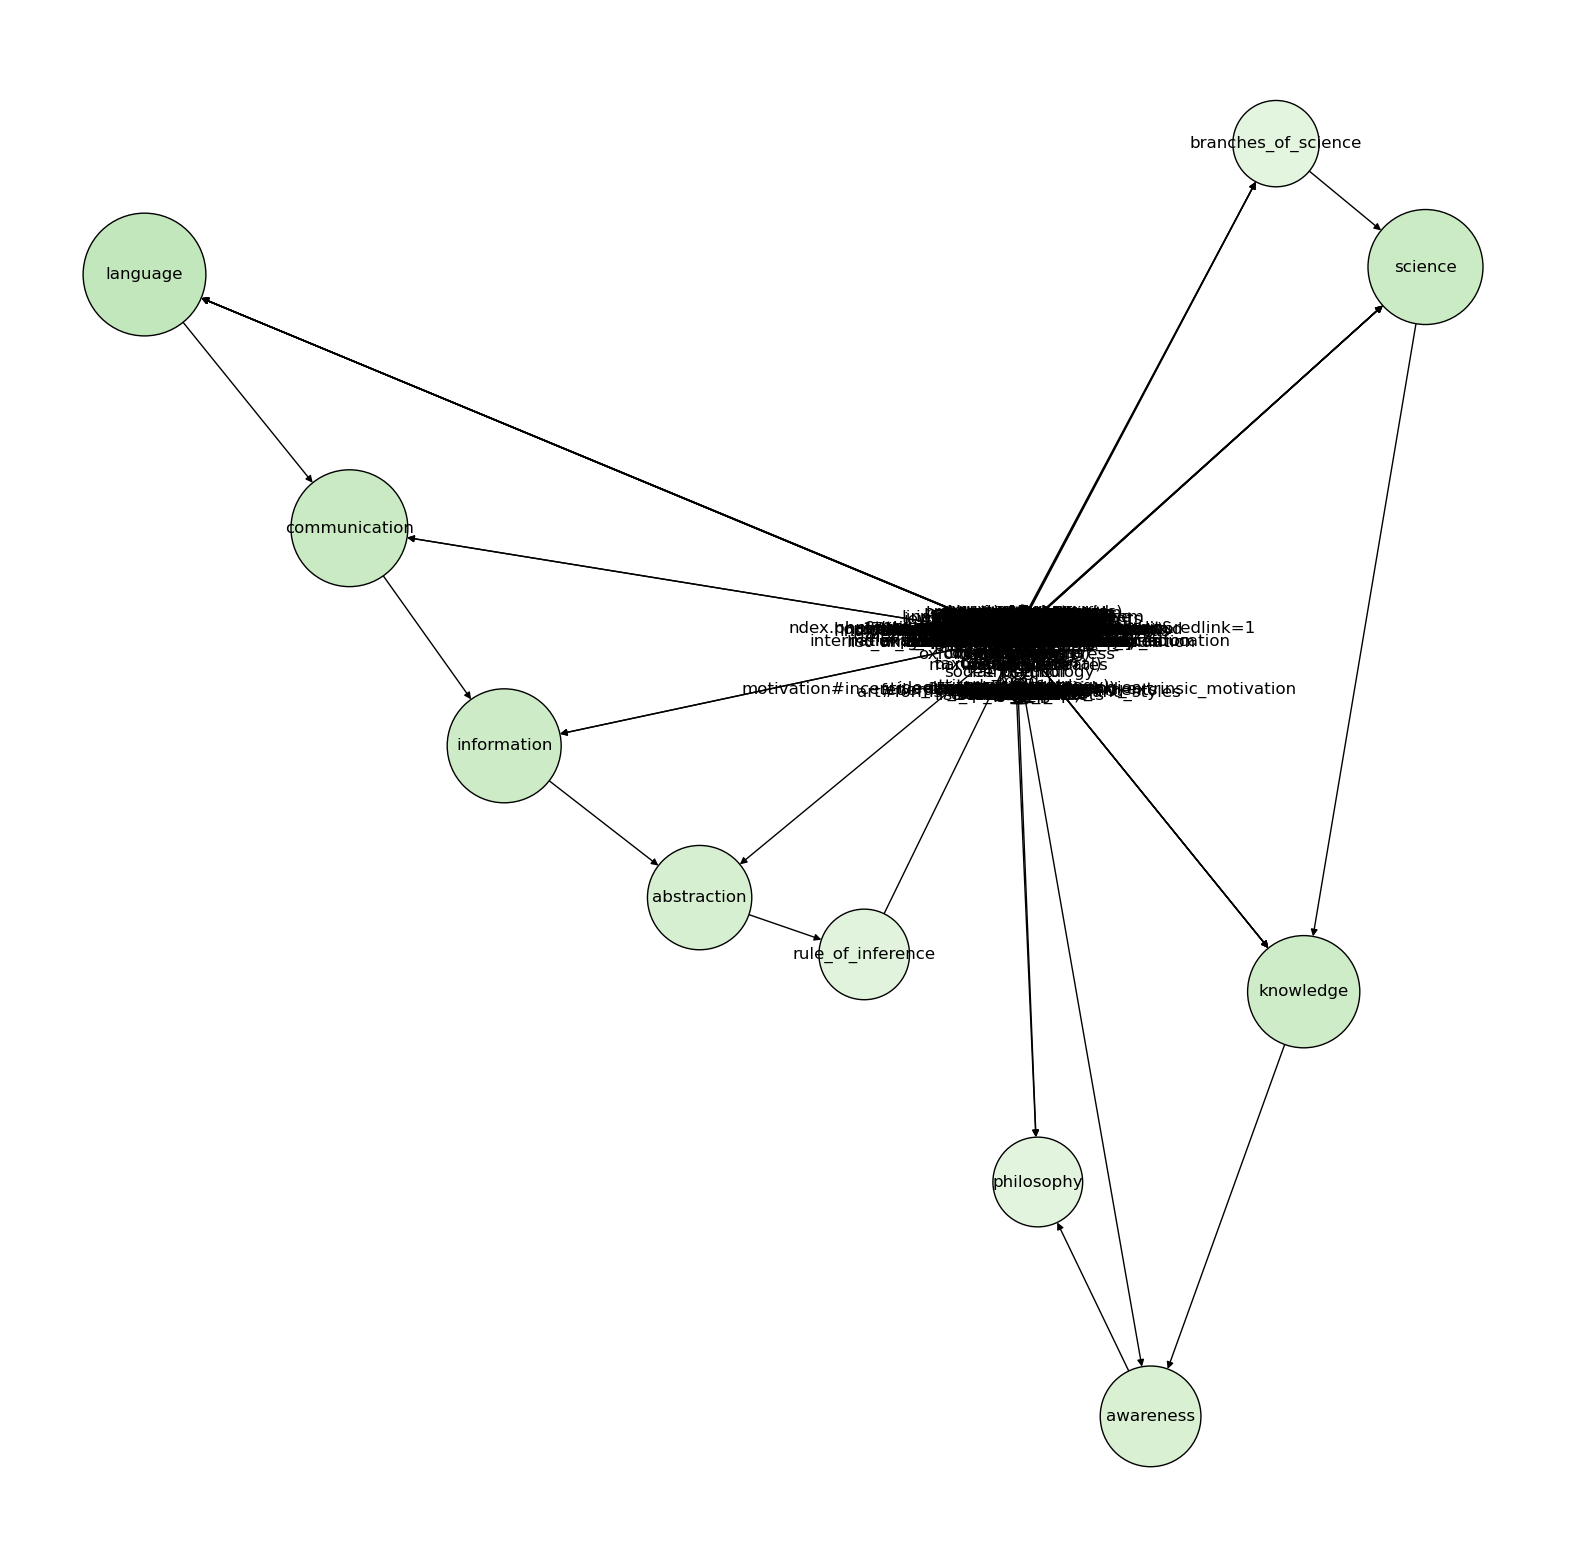

In [246]:
plot_network(subgraph, node_color="betweeness", layout="spectral")

In [188]:
path_appearances = []
for node in G.nodes:
    count = 0
    for path in paths:
        if node in path:
            count +=1
    
    path_appearances.append(count)

path_count_df = pd.DataFrame({"node":G.nodes, "appearances":path_appearances})
path_count_df = path_count_df.sort_values("appearances", ascending=False)
path_count_df.reset_index(inplace=True)
path_count_df.pop("index")

# Remove philosophy
path_count_df = path_count_df[1:]
path_count_df.head(80)

,node,appearances
1,philosophy_of_logic,717
2,rule_of_inference,716
3,abstraction,715
4,information,704
5,communication,681
...,...,...
76,environment_(systems),24
77,intellect,23
78,sociolinguistics,23
79,system,23
